In [ ]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms

train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64,
                                           num_workers=0)

100%|██████████| 9912422/9912422 [00:00<00:00, 254578421.94it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 91908720.66it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 144699056.32it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 14860006.84it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, i, h, o):
        super(Discriminator, self).__init__()

        # define linear layers
        self.d1 = nn.Linear(i, h*4)
        self.d2 = nn.Linear(h*4, h*2)
        self.d3 = nn.Linear(h*2, h)
        self.d4 = nn.Linear(h, o)

        self.dropout = nn.Dropout(0.3)


    def forward(self, x):
        x = x.view(-1, 28*28)

        # all hidden layers
        x = F.leaky_relu(self.d1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.d2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.d3(x), 0.2)
        x = self.dropout(x)
        out = self.d4(x)

        return out

In [ ]:
class Generator(nn.Module):

    def __init__(self, i, h, o):
        super(Generator, self).__init__()

        # define linear layers
        self.g1 = nn.Linear(i, h)
        self.g2 = nn.Linear(h, h*2)
        self.g3 = nn.Linear(h*2, h*4)
        self.g4 = nn.Linear(h*4, o)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.g1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.g2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.g3(x), 0.2)
        x = self.dropout(x)
        out = F.tanh(self.g4(x))

        return out

In [ ]:
# Discriminator hyperparams

d_input = 784
d_output = 1
d_hidden = 32

# Generator hyperparams

g_z = 100
g_output = 784
g_hidden = 32

In [ ]:
# instantiate discriminator and generator
D = Discriminator(d_input, d_hidden, d_output)
G = Generator(g_z, g_hidden, g_output)

In [ ]:
# Calculate losses
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1

    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss


In [ ]:
import torch.optim as optim

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), 0.002)
g_optimizer = optim.Adam(G.parameters(), 0.002)


In [ ]:
import pickle as pkl

num_epochs = 100

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, 100))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):

    for batch_i, (real_images, _) in enumerate(train_loader):

        batch_size = real_images.size(0)

        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)

        # Discriminator
        d_optimizer.zero_grad()

        # 1. Train with real images
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)

        # 2. Train with fake images
        z = np.random.uniform(-1, 1, size=(batch_size, 100))
        z = torch.from_numpy(z).float()
        fake_images = G(z)

        # Compute the discriminator losses on fake images
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)

        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()

        # Generator
        g_optimizer.zero_grad()

        # 1. Train with fake images and flipped labels
        z = np.random.uniform(-1, 1, size=(batch_size, 100))
        z = torch.from_numpy(z).float()
        fake_images = G(z)

        # Compute the discriminator losses on fake images
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels

        # perform backprop
        g_loss.backward()
        g_optimizer.step()

    print('Epoch [{:5d}/{:5d}] | discriminator_loss: {:6.4f} | generator_loss: {:6.4f}'.format(epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))

    # generate and save sample, fake images
    G.eval()
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/  100] | discriminator_loss: 1.4197 | generator_loss: 1.1513
Epoch [    2/  100] | discriminator_loss: 1.0829 | generator_loss: 3.8986
Epoch [    3/  100] | discriminator_loss: 0.8412 | generator_loss: 4.3261
Epoch [    4/  100] | discriminator_loss: 0.6083 | generator_loss: 6.0892
Epoch [    5/  100] | discriminator_loss: 1.1126 | generator_loss: 1.8063
Epoch [    6/  100] | discriminator_loss: 0.8049 | generator_loss: 2.5901
Epoch [    7/  100] | discriminator_loss: 1.0888 | generator_loss: 1.4457
Epoch [    8/  100] | discriminator_loss: 1.1602 | generator_loss: 1.6152
Epoch [    9/  100] | discriminator_loss: 1.0853 | generator_loss: 1.2820
Epoch [   10/  100] | discriminator_loss: 1.0865 | generator_loss: 1.5265
Epoch [   11/  100] | discriminator_loss: 1.2905 | generator_loss: 0.9853
Epoch [   12/  100] | discriminator_loss: 1.2173 | generator_loss: 1.1293
Epoch [   13/  100] | discriminator_loss: 1.2655 | generator_loss: 1.2315
Epoch [   14/  100] | discriminator_lo

In [ ]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [ ]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

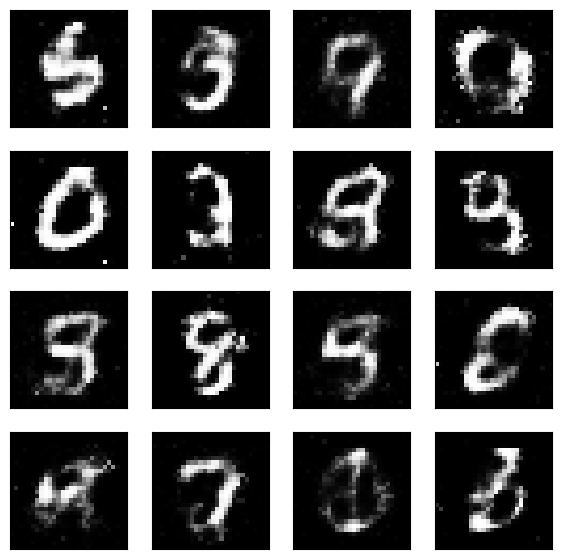

In [ ]:
view_samples(-1, samples)

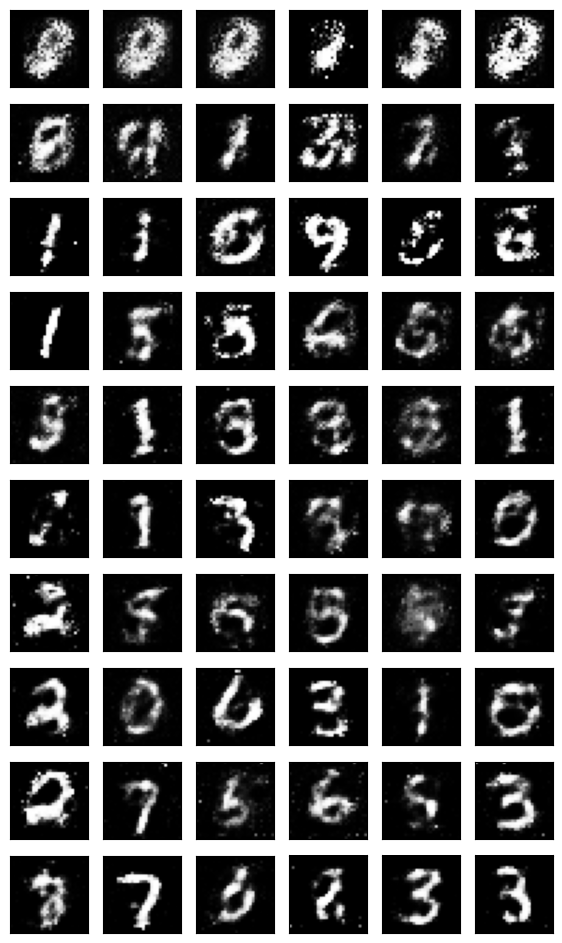

In [ ]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)